In [103]:
import aerosandbox as asb
import aerosandbox.numpy as np
from tqdm import tqdm

from aerosandbox.tools.pretty_plots import plt, sns, mpl, show_plot

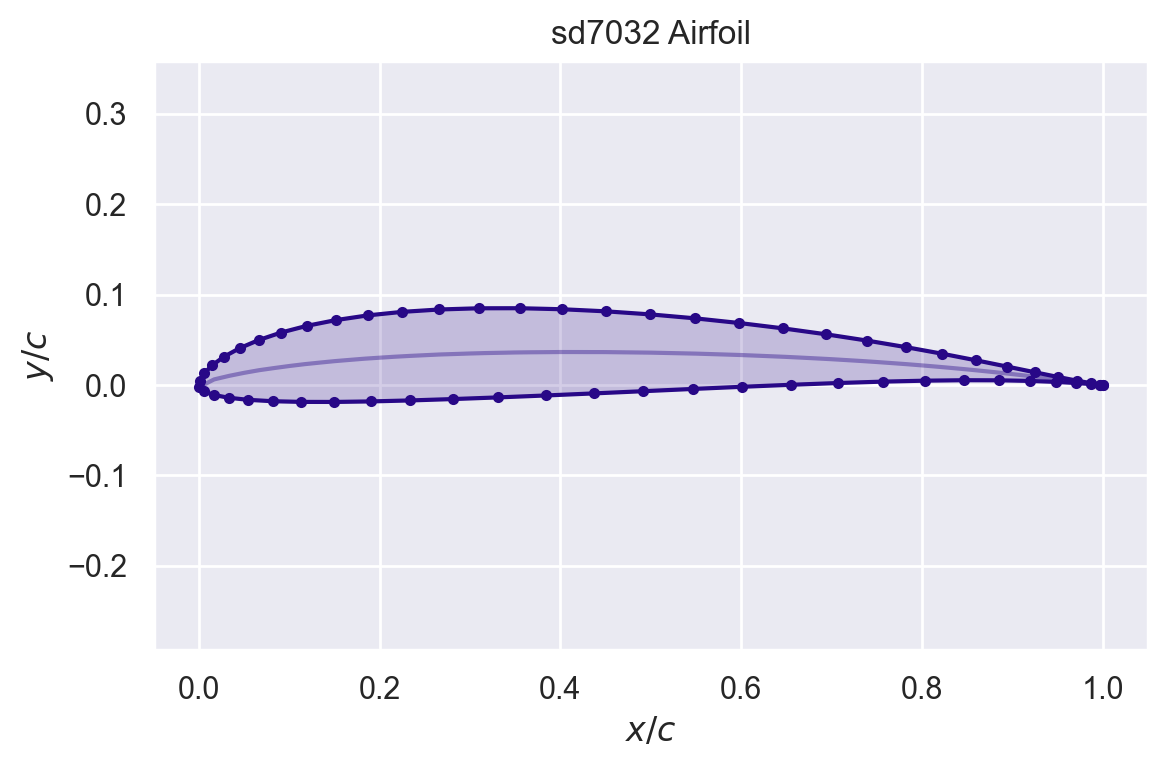

100%|██████████| 21/21 [00:06<00:00,  3.05it/s]


In [104]:
a = asb.Airfoil("sd7032")

fig, ax = plt.subplots()
a.draw(backend='matplotlib')
plt.show()

Res = np.geomspace(1e3, 1e6, 21)
alpha_upper = np.linspace(3, 16, 14)
alpha_lower = np.linspace(3, -3, 7)[1:]
data = None


def add_to_data(run_data):
    global data
    if data is None:
        data = run_data
    else:
        data = {
            k: np.hstack((
                data[k],
                run_data[k]
            ))
            for k in data.keys()
        }


for Re in tqdm(Res):
    xf = asb.XFoil(
        airfoil=a,
        Re=Re,
        max_iter=20
    )
    run_data = xf.alpha(alpha_upper)
    run_data["Re"] = np.full_like(run_data["alpha"], Re)
    add_to_data(run_data)

    run_data = xf.alpha(alpha_lower)
    run_data["Re"] = np.full_like(run_data["alpha"], Re)
    add_to_data(run_data)

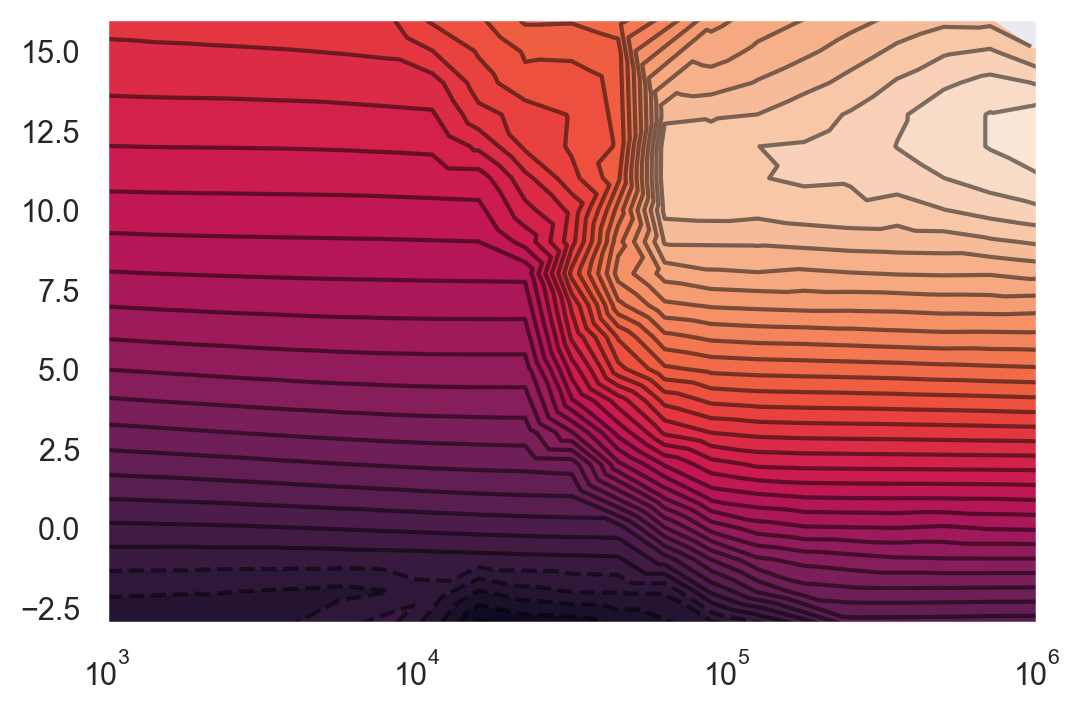

In [105]:
fig, ax = plt.subplots()


def tricontour(*args, levels=40, **kwargs):
    plt.tricontour(*args, levels=levels, **kwargs, colors="k", alpha=0.5)
    plt.tricontourf(*args, levels=levels, **kwargs)


tricontour(
    data["Re"],
    data["alpha"],
    data["CL"],
)
plt.xscale('log')

RBF Interpolation

In [106]:
alphas = np.hstack((
    alpha_upper,
    alpha_lower
))
alphas = np.sort(alphas)
res = np.geomspace(1e3, 1e6, 30)
Alphas, Res = np.meshgrid(alphas, res)

from scipy.interpolate import Rbf

rbf = Rbf(
    np.log10(data["Re"]),
    data["alpha"],
    data["CL"],
    function='linear',
)
CL_rbf = rbf(
    np.log10(Res.flatten()),
    Alphas.flatten(),
).reshape(Alphas.shape)


Interpolation and plotting

<ipython-input-161-e87562412790>:60: RuntimeWarning:

divide by zero encountered in log10



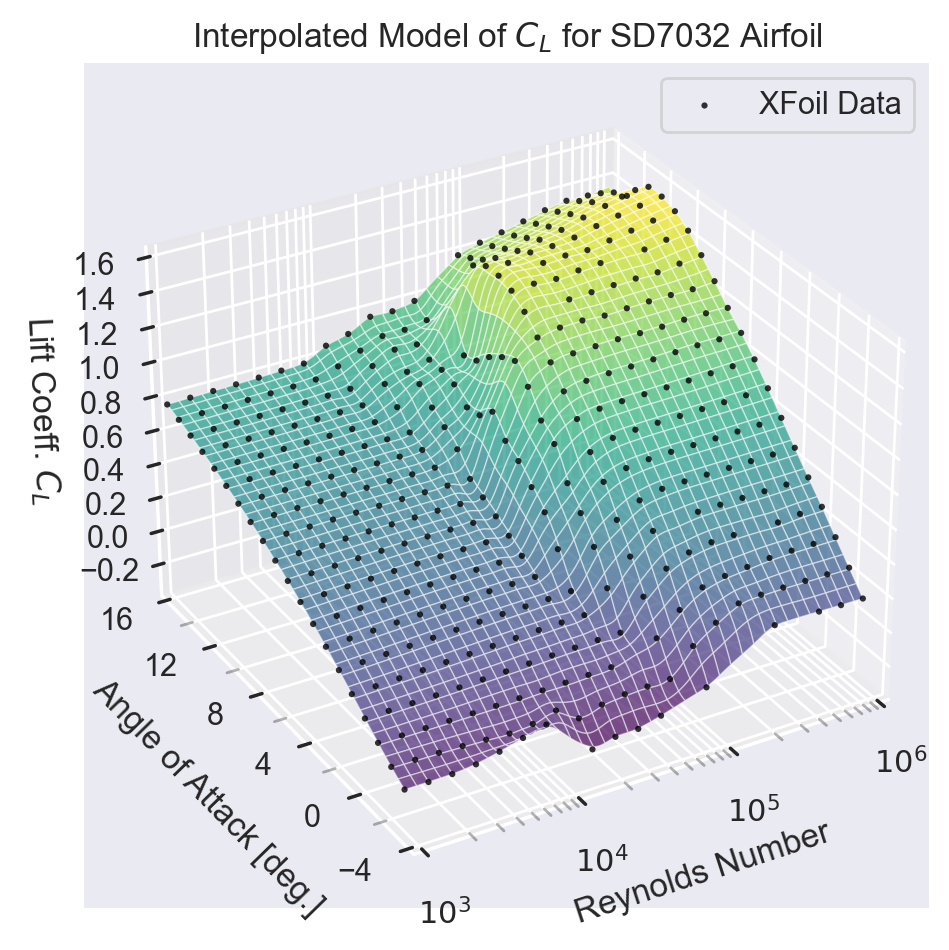

In [161]:
im = asb.InterpolatedModel(
    x_data_coordinates={
        "Re"   : np.log10(res),
        "alpha": alphas,
    },
    y_data_structured=CL_rbf
)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(
    np.log10(data["Re"]),
    data["alpha"],
    data["CL"] + 1e-12,
    marker=".", color="k", alpha=0.8, linewidth=0, label="XFoil Data"
)

# ax.plot_surface(
#     np.log10(Res),
#     Alphas,
#     CL_rbf,
#     cmap=plt.cm.viridis,
#     edgecolors=(1, 1, 1, 0.5),
#     linewidth=0.5,
#     alpha=0.7,
#     rcount=40,
#     ccount=40,
#     shade=True,
# )
res_plot = np.geomspace(res.min(), res.max(), 200)
alphas_plot = np.linspace(alphas.min(), alphas.max(), 200)
Res_plot, Alphas_plot = np.meshgrid(res_plot, alphas_plot)

ax.plot_surface(
    np.log10(Res_plot),
    Alphas_plot,
    im({
        "Re"   : np.log10(Res_plot.flatten()),
        "alpha": Alphas_plot.flatten()
    }).reshape(Alphas_plot.shape),
    # cmap=plt.cm.viridis,
    cmap=sns.color_palette("viridis", as_cmap=True),
    edgecolors=(1, 1, 1, 0.5),
    linewidth=0.5,
    alpha=0.7,
    rcount=40,
    ccount=40,
    shade=True,
)


def log_tick_formatter(val, pos=None):
    return r"$10^{:.0f}$".format(val)


ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator(
    np.array([
        np.log10(b * 10 ** e)
        for b in range(10)
        for e in [3, 4, 5]
    ])
))
ax.xaxis.set_tick_params(which='minor', color=(0,0,0,0.3))
plt.xlim(3, 6)
plt.setp(ax.xaxis.get_majorticklabels(), ha="center")

ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(4))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(2))
ax.yaxis.set_tick_params(which='minor', color=(0,0,0,0.3))
plt.ylim(-4, 16)
plt.setp(ax.yaxis.get_majorticklabels(), ha="right", va="bottom")
# ax.grid('major', linewidth=1.6)
# ax.grid(True, 'minor', linewidth=0.7)

ax.zaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))

ax.view_init(30, -120)
ax.set_xlabel("Reynolds Number")
ax.set_ylabel(r"Angle of Attack [deg.]")
ax.set_zlabel(r"Lift Coeff. $C_L$")
plt.title(f"Interpolated Model of $C_L$ for {a.name.upper()} Airfoil")
plt.legend()
plt.subplots_adjust(
    bottom=0.055,
    left=0,
    right=1,
    top=0.90
)
show_plot(
    pretty_grids=False,
    tight_layout=False,
    show=False
)
# plt.savefig(r"C:\Users\User\Dropbox (MIT)\School\Grad School\2021 Spring\Thesis\TeX\figures\interpolated-xfoil-3d.pgf")
plt.show()

